In [3]:
import numpy as np
import cv2
import sys
import time
from pixellib.semantic import semantic_segmentation
from pixellib.instance import instance_segmentation
from pixellib.tune_bg import alter_bg
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import *
import tensorflow as tf

### 9.3.5 프로그래밍 실습: YOLO v3으로 물체 검출

In [8]:
def construct_yolo_v3():
    f = open("./saved_model/coco_names.txt", 'r')
    class_names = [line.strip() for line in f.readlines()]
    
    model =cv2.dnn.readNet("./saved_model/yolov3.weights", "./saved_model/yolov3.cfg")
    layer_names = model.getLayerNames()
    out_layers = [layer_names[i-1] for i in model.getUnconnectedOutLayers()]
    
    return model, out_layers, class_names


def yolo_detect(img, yolo_model, out_layers):
    height, width = img.shape[0], img.shape[1]
    test_img = cv2.dnn.blobFromImage(img, 1.0/256, (448, 448), (0, 0, 0), swapRB=True)
    yolo_model.setInput(test_img)
    output3 = yolo_model.forward(out_layers)
    
    box, conf, id = [], [], []
    for output in output3:
        for vec85 in output:
            scores = vec85[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                centerx, centery = int(vec85[0]*width), int(vec85[1]*height)
                w, h = int(vec85[2]*width), int(vec85[3]*height)
                x, y = int(centerx - w/2), int(centery - h/2)
                box.append([x, y, x+w, y+h])
                conf.append(float(confidence))
                id.append(class_id)
    ind = cv2.dnn.NMSBoxes(box, conf, 0.5, 0.4)
    objects = [box[i] + [conf[i]] + [id[i]] for i in range(len(box)) if i in ind]
    return objects


model, out_layers, class_names = construct_yolo_v3()
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

img = cv2.imread("./imgs/soccer.jpg")

res = yolo_detect(img, model, out_layers)

for i in range(len(res)):
    x1, y1, x2, y2, confidence, id = res[i]
    text = str(class_names[id]) + "%.3f" %confidence
    cv2.rectangle(img, (x1, y1), (x2, y2), colors[id], 2)
    cv2.putText(img, text, (x1, y1+30), cv2.FONT_HERSHEY_PLAIN, 1.5, colors[id], 2)
    
cv2.imshow("Object detection by YOLO v.3", img)
cv2.waitKey()
cv2.destroyAllWindows()

In [14]:
cap = cv2.VideoCapture("video/boy.mov")

start = time.time()
n_frame = 0
while True:
    ret, frame = cap.read()
    
    res = yolo_detect(frame, model, out_layers)
    
    for i in range(len(res)):
        x1, y1, x2, y2, confidence, id = res[i]
        text = str(class_names[id]) + "%.3f"%confidence
        cv2.rectangle(frame, (x1, y1), (x2, y2), colors[id], 2)
        cv2.putText(frame, text, (x1, y1+30), cv2.FONT_HERSHEY_PLAIN, 1.5, colors[id], 2)
    
    cv2.imshow("object detection from video by YOLO v.3", frame)
    n_frame += 1
    
    key = cv2.waitKey(1)
    if key == ord('q'): break

end = time.time()
print("처리한 프레임수 =", n_frame, ", 경과시간=", end-start, "\n초당 프레임 수=", n_frame/(end-start))

cap.release()
cv2.destroyAllWindows()

처리한 프레임수 = 23 , 경과시간= 6.642044544219971 
초당 프레임 수= 3.4627891828902326


* Oxford Data

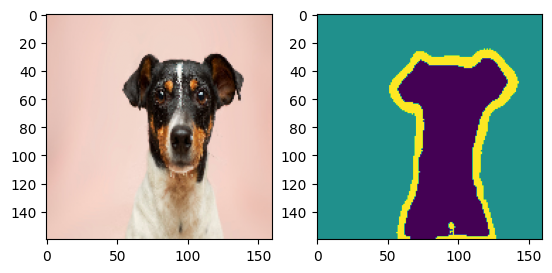

In [51]:
model = tf.keras.models.load_model("./saved_model/oxford_pet.h5", compile=False)
img = cv2.imread("./imgs/dogs.jpg")[..., ::-1]
img = cv2.resize(img, [160, 160]) / 255
img = np.expand_dims(img, 0)
out = np.argmax(model.predict(img), -1)[0, ..., None]

plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.subplot(1, 2, 2)
plt.imshow(out)

### 9.4.5 pixellib 라이브러리를 이용한 프로그래밍 실습

Processed Image saved successfuly in your current working directory.


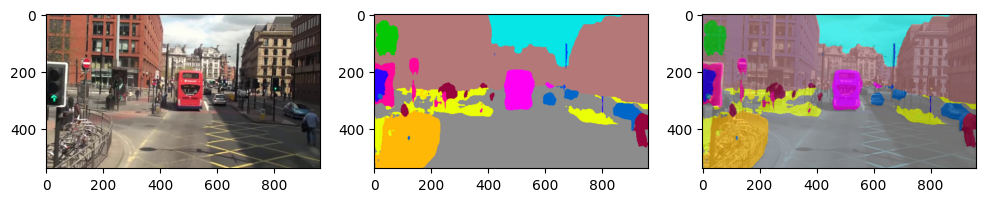

In [53]:
# 정지 이미지 semantic segmentation
seg = semantic_segmentation()
seg.load_ade20k_model("./saved_model/deeplabv3_xception65_ade20k.h5")


img_fname = "./imgs/mot_color70.jpg"
seg.segmentAsAde20k(img_fname, output_image_name="image_new.jpg")
info1, img_segmented1 = seg.segmentAsAde20k(img_fname)
info2, img_segmented2 = seg.segmentAsAde20k(img_fname, overlay=True)


plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(cv2.imread(img_fname)[..., ::-1])
plt.subplot(1, 3, 2)
plt.imshow(img_segmented1[..., ::-1])
plt.subplot(1, 3, 3)
plt.imshow(img_segmented2[..., ::-1])

In [55]:
# 비디오 semantic segmentation
cap = cv2.VideoCapture("./video/street.mp4")

seg_video = semantic_segmentation()
seg_video.load_ade20k_model("./saved_model/deeplabv3_xception65_ade20k.h5")

seg_video.process_camera_ade20k(cap, overlay=True, frames_per_second=2, output_video_name="output_video.mp4",
                               show_frames=True, frame_name="Pixellib")

cap.release()
cv2.destroyAllWindows()

C:\Users\82104\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1296,4,4,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node aspp3_depthwise_7/depthwise/SpaceToBatchND}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[decoder_conv0_depthwise_BN_7/cond/else/_2998/FusedBatchNormV3/_61409]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1296,4,4,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node aspp3_depthwise_7/depthwise/SpaceToBatchND}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
# 정지 이미지 instance segmentation
seg = instance_segmentation()
seg.load_model("./saved_model/mask_rcnn_coco.h5")

img_fname = "./imgs/busy_street.jpg"
infro, img_segmented = seg.segmentImage(img_frname, show_bboxe=True)

plt.imshow(img_segmented[... ::-1])

In [ ]:
# 비디오 instance segmentation
cap = cv2.VideoCapture("./")

seg_video = instance_segmentation()
seg_video.load_model("mask_rcnn_coco.h5")

target_class = seg_video.select_target_classese(person=True)
seg_video.process_camera(cap, segment_target_classes=target_calss, frames_per_second=2,
                        show_frames=True, frame_name="Pixellib", show_bboxes=True)

cap.release()
cv2.destroyAllWindows()

## 9.5 배경을 내 맘대로 바꾸기

In [ ]:
class VideoSpecialEffect(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle('배경을 내 맘대로')
        self.setGeometry(200,200,400,100)
       
        videoButton=QPushButton('배경 내 맘대로 켜기',self)
        self.pickCombo=QComboBox(self)     
        self.pickCombo.addItems(['원래 영상','흐릿(조금)','흐릿(중간)','흐릿(많이)','빨강','녹색','파랑'])
        quitButton=QPushButton('나가기',self)        
        
        videoButton.setGeometry(10,10,140,30)
        self.pickCombo.setGeometry(150,10,110,30)                  
        quitButton.setGeometry(280,10,100,30)
        
        videoButton.clicked.connect(self.videoSpecialEffectFunction) 
        quitButton.clicked.connect(self.quitFunction)
        
    def videoSpecialEffectFunction(self):             
        self.cap=c2v.VideoCapture(0,cv2.CAP_DSHOW) 
        if not self.cap.isOpened(): sys.exit('카메라 연결 실패')
        
        while True:
            ret,frame=self.cap.read()  
            if not ret: break

            pick_effect=self.pickCombo.currentIndex()        
            if pick_effect==0:
                special_img=frame
            elif pick_effect==1:
                special_img=change_bg.blur_frame(frame,low=True,detect='person')
            elif pick_effect==2:
                special_img=change_bg.blur_frame(frame,moderate=True,detect='person')
            elif pick_effect==3:    
                special_img=change_bg.blur_frame(frame,extreme=True,detect='person')
            elif pick_effect==4:    
                special_img=change_bg.color_frame(frame,colors=(255,0,0),detect='person')
            elif pick_effect==5:    
                special_img=change_bg.color_frame(frame,colors=(0,255,0),detect='person')
            elif pick_effect==6:    
                special_img=change_bg.color_frame(frame,colors=(0,0,255),detect='person')
                
            cv2.imshow('Special effect',special_img)              
            cv2.waitKey(1) 
                                        
    def quitFunction(self):
        self.cap.release()
        cv2.destroyAllWindows()        
        self.close()

change_bg=alter_bg(model_type="pb")
change_bg.load_pascalvoc_model('./saved_model/xception_pascalvoc.pb')
                
app = QCoreApplication.instance()
if app is None:
    app = QApplication(sys.argv)
win = BeepSound()
win.show()
app.exec_()